# MSCF 46982 Market Microstructure and Algorithmic Trading
# Fall 2025 Mini 2

Before you turn this assignment in, make sure everything runs as
expected. First, **restart the kernel**: by selecting
Kernel$\rightarrow$Restart Kernel from the menubar (or the `0,0`
keyboard shortcut) and then **run all cells** by selecting
Run$\rightarrow$Run All Cells from the menubar.

Make sure you replace all instances `YOUR CODE HERE` or "YOUR ANSWER
HERE" with your solution and remove the `notimplemented` exception.


As indicated in the syllabus, you are encouraged to discuss the
material presented in class but not of the specifics of assignments
(including this one).


---

In [1]:
import os
os.environ['PYKX_JUPYTERQ'] = 'true'
os.environ['PYKX_4_1_ENABLED'] = 'true'
import pykx as kx


<frozen importlib._bootstrap>:488: PyKXWarning: Unable to connect user QHOME to PyKX QHOME via symlinks.
To permanently disable attempts to create symlinks you can
	1. Set the environment variable "PYKX_IGNORE_QHOME" = True.
	2. Update the file ".pykx-config" using kx.util.add_to_config({'PYKX_IGNORE_QHOME': 'True'})
Error: [WinError 1314] A required privilege is not held by the client: 'C:\\Users\\jacob\\Desktop\\Fin Computing I\\Mkt Micro and Algo\\.cmu_userpass.txt' -> 'C:\\Users\\jacob\\Desktop\\Fin Computing I\\env\\Lib\\site-packages\\pykx\\lib\\4-1-libs\\.cmu_userpass.txt'



PyKX now running in 'jupyter_qfirst' mode. All cells by default will be run as q code. 
Include '%%py' at the beginning of each cell to run as python code. 


## Analyzing trade data from a CSV
Comma Separated Value (CSV) files are a popular means of data storage,
but they lack the type precision of other formats (such as JSON or
binary).  Kdb+ provides a simple and flexible interface to parsing
text from CSV files into a table with proper types for each column. We
can then use Kdb+'s `q-sql` syntax to perform data analysis.


### Part A (2 Points)

This question has been started for you by downloading sample [trade
data][TD] from the NYSE Daily TAQ (Trade And Quote) database into a
variable `txt`.  Supply the correct arguments to the `0:` operator to
load the "Symbol", "Trade Time", "Trade Size", "Trades Price" and
"Trade Condition" columns into a table `t` with data types: symbol,
timestamp, integer, real.

[TD]:
https://tpr-mscf-kx.tepper.cmu.edu:5000/hw2.csv
"Sample Trade Data"

NOTE: The database is located on a CMU server - behind the firewall.
If you are doing this assignment from home, you will need to connect
to the CMU network using the [Cisco AnyConnect VPN][] software.

[Cisco AnyConnect VPN]:
https://www.cmu.edu/computing/services/endpoint/network-access/vpn/index.html
"Cisco AnyConnect VPN"


In order to authenticate to the Kdb+ server, you must supply your
andrewid and password. To keep your password encrypted during
transport, the Kdb+ server uses Transport Layer Security ([TLS][]).
In other words, the protocol used is 'https' and not 'http'.

To allow the Jupyter notebooks to authenticate without prompting, you
will need to store your "andrewid:password" in a text file called
'cmu_userpass.txt' in your home directory. The following cell shows
you the expected path for this file.

[TLS]: https://en.wikipedia.org/wiki/Transport_Layer_Security "Transport Layer Security"

Again, the only text required in this file is your andrewid and
password joined by a colon.



In [2]:
` sv hsym[`$getenv`HOME],`cmu_userpass.txt

.cmu_userpass.txt


In [3]:
\c 10 100
txt:.Q.hg "https://",(first read0 ` sv hsym[`$getenv`HOME],`cmu_userpass.txt),"@tpr-mscf-kx.tepper.cmu.edu:5000/hw2.csv"
t:("SP IEC";enlist csv) 0: txt
show t

In [4]:
rnd:{x*"j"$y%x}
assert:{if[not x~y;'"expecting '",(-3!x),"' but found '",(-3!y),"'"]}
/ confirm the table count is corret
assert[229184] count t
/ confirm the columns are correct
assert[`$("Symbol";"Trade Time";"Trade Size";"Trade Price";"Trade Condition")] cols t
/ confirm the column types are correct
assert["spiec"] value[meta t]`t
/ confirm the Symbol column has data for `BAC`TSLA
assert[`BAC`TSLA] distinct t`Symbol

### Part B (2 Points)

The column names of this table have spaces - making them incompatible
with `q-sql`.  The operator `.Q.id` removes these illegal characters,


In [5]:
cols .Q.id t

`Symbol`TradeTime`TradeSize`TradePrice`TradeCondition


but leaves names that are too verbose (at least for my taste).  This
question asks you to use the `xcol` operator to rename the columns
such that they can be queried with `q-sql`.

Rename the columns to: `sym`, `time`, `size`, `price`, and `cond`

In [6]:
t: `sym`time`size`price`cond xcol t

In [7]:
/ check that the columns are correct
assert[`sym`time`size`price`cond] cols t

### Part C (3 Points)

We learned that tables are flipped dictionaries of lists -- where the
column headers are stored as a vector of symbols and each column is a
vector of values.  We also learned that kdb+ employs 'copy on write'
semantics to minimize copying of data.  This question asks that you
circumvent this logic.  Complete the `deepcopy` function such that it
returns a copy of the supplied table that has no references to the
original table.


In [8]:
deepcopy:{[t]
 c:`$string cols t;
 v:{@[x;0;:;x 0]}each value flip t;
 flip c!v}

In [9]:
/ check that t and and the table returned by deepcopy are identical
assert[t] deepcopy t
/ check that t is not referred to by anything else
assert[0i] -16!deepcopy t
/ check that each column of t is not referred to by anything else
assert[0i] max -16!/: deepcopy[t]`sym`time`size`price`cond
/ prevent referring to global variables!
assert[1#`] get[deepcopy] 3

In [10]:
/ check that the column name vector of t is not referred to by anything else
assert[0i] -16!cols deepcopy t

### Part D (3 Points)

Using the `where` clause with `q-sql`, complete the `filter` function
to limit the dataset to only the list of symbols passed as function
argument, and only those rows that have a null condition code.


In [11]:
filter:{[s;t]
 select from t where sym in s, null cond}

In [12]:
/ check that the query returns only the desired symbols
assert[1#`BAC] distinct filter[`BAC;t]`sym
assert[1#`TSLA] distinct filter[`TSLA;t]`sym
/ check that the returned rows have the expected data
assert[68854] count filter[`BAC;t]
assert[23799] count filter[`TSLA;t]
assert[92653] count filter[`BAC`TSLA;t]

In [13]:
/ check that the function is implemented efficiently
assert[1b] 4325888>=0N!last system "ts filter[`BAC;t]"

### Part E (3 Points)

We are looking to generate a volatility profiles from this dataset.
The first step is to generate a table with the open, high, low, close
values from each minute of the trading day. Complete the `ohlc`
function to return these values for all the symbols in table `t`.  The
resulting table should have a two column primary key (sym and time)
and four other columns (`o`, `h`, `l`, `c`).

HINT: to compute the minute portion of a time value within `q-sql`,
you can use `0D0:01 xbar time` syntax.


In [14]:
ohlc:{[t]
 select o:first price, h:max price, l:min price, c:last price by sym, 0D00:01 xbar time from t}

In [15]:
/ check that the function returns the correct columns
assert[`sym`time`o`h`l`c] cols ohlc filter[`BAC] t
/ check that the table has the correct number of rows
assert[390] count ohlc filter[`BAC] t
/ check that the data is correct
assert[`o`h`l`c!31.05 31.06 31.04 31.05] rnd[.01] avg ohlc filter[`BAC] t

In [16]:
/ check that the function is implemented efficiently
tf:filter[`BAC] t
assert[1b] 7340368>=0N!last system "ts ohlc tf"

### Part F (3 Points)

The Garman-Klass volatility estimator extends the Parkinson volatility
estimator reviewed in class.  In addition to the high and low prices,
it also uses the open and close prices.

$$
\sigma(n)_{gk}=\sqrt{\frac{1}{n}\sum_{i=0}^n\frac{1}{2}\left(\ln(\frac{h_i}{l_i})\right)^2-(2\ln(2)-1)\left(\ln(\frac{c_i}{o_i})\right)^2
$$

Similar to the Parkinson volatility estimator, the Garman-Klass
volatility estimator:

- assumes markets are continuous and **tends to underestimate
  volatility** because it ignores inter-interval jumps
- assumes zero drift and **may overestimate volatility** in a trending
  market

Complete the `gk` function with a simplified implementation of the
Garman-Klass measure that produces a variance (volatility squared)
without averaging over observations.  For flexibility we will let the
caller compute the average (or moving average), annualize the values,
and then take the square root.

$$
\sigma_{gk}^2=\frac{1}{2}\left(\ln(\frac{h}{l})\right)^2-(2 \ln(2)-1)\left(\ln(\frac{c}{o})\right)^2
$$

HINT: addition is faster than subtraction and the effect is obviously
compounded for vectors


In [17]:
/ garman-klass variance estimator
gk:{[o;h;l;c]
 (0.5*x*x:log h%l)+(1-2*log 2)*x*x:log c%o}

In [18]:
/ check that the gk function produces the correct values
assert[0n 1.7222 1.7222 1.1781] rnd[1e-4] gk . (first;max;min;last)@\: 4 cut sums 100#01b

In [19]:
/ check that your function is implemented efficiently
assert[1b] 68320>=0N!last system"ts gk . 4 0N#4000?1f"

### Part G (3 Points)

The open, high, low and close columns are useful when computing the
intraday volatility.  Using `q-sql`, complete the `addvol` function to
add a new column `volatility` to table `t`. The function should uses
the open, high, low and close values along with the `gk` function to
compute a variance values for each minute.  It should then use the
`mavg` function to compute a moving average over window `w`.  Finally,
it should convert the **variance** numbers to **volatility**. Make
sure to annualize the numbers with 6.5 hours in a trading day and 252
trading days per year.


In [20]:
addvol:{[w;t]
 update volatility:sqrt 98280*mavg[w;gk[o;h;l;c]] by sym from t}

In [21]:
/ check that the table now has the volatility column
assert[1b] `volatility in cols addvol[5] ohlc filter[`BAC] t
/ check that the volatility values are correct
assert[`BAC`TSLA!0.1318 0.2949] rnd[1e-4] exec avg volatility by sym from addvol[5] ohlc filter[`BAC`TSLA] t

In [22]:
/ check that your function is implemented efficiently
ohlct:ohlc filter[`BAC] t
assert[1b] 32304>=0N!last system"ts addvol[5] ohlct"

### Part H (2 Points)

In combination with the `filter`, `ohlc` and the `addvol` functions,
use the `pivot` function to generate a time series of BAC and TSLA's
volatility (using a moving window of 5).  The result should be saved
into a table `s` and have three columns: time (the primary key), BAC
and TSLA.


In [23]:
/ create pivot (t)able with data from the last column
/ pivot columns from the last key column
/ and pivot keys as all but the last key column
pivot:{[t]
 u:`$string asc distinct last f:flip key t;
 pf:{x#(`$string y)!z};
 p:?[t;();g!g:-1_ k;(pf;`u;last k:key f;last key flip value t)];
 p} 

In [24]:
s:{update BAC:first each BAC, TSLA:first each TSLA from x} pivot select volatility by time, sym from addvol[5] ohlc filter[`BAC`TSLA;t]

In [25]:
/ check that the table has the correct columns
assert[`time`BAC`TSLA] cols s
/ check that the table has the right number of rows
assert[390] count s
/ check that the avg volatility 
assert[`BAC`TSLA!0.1318 0.2949] rnd[1e-4] avg s

### Part I (2 Points)

Integrating Kdb+ with Jupyter Notebooks allows you to use the power of
python's plotting tools.

This problem requests that you to copy the table `s` from the q memory
space into the python memory space and call it `s`.


In [26]:
.pykx.set[`s] .pykx.topd s

In [27]:
/ check that the python variable df now contains exactly the same data as the q variable s
assert[s] .pykx.get[`s]`

<Axes: title={'center': 'BAC vs TSLA Intraday Volatility'}, xlabel='time'>

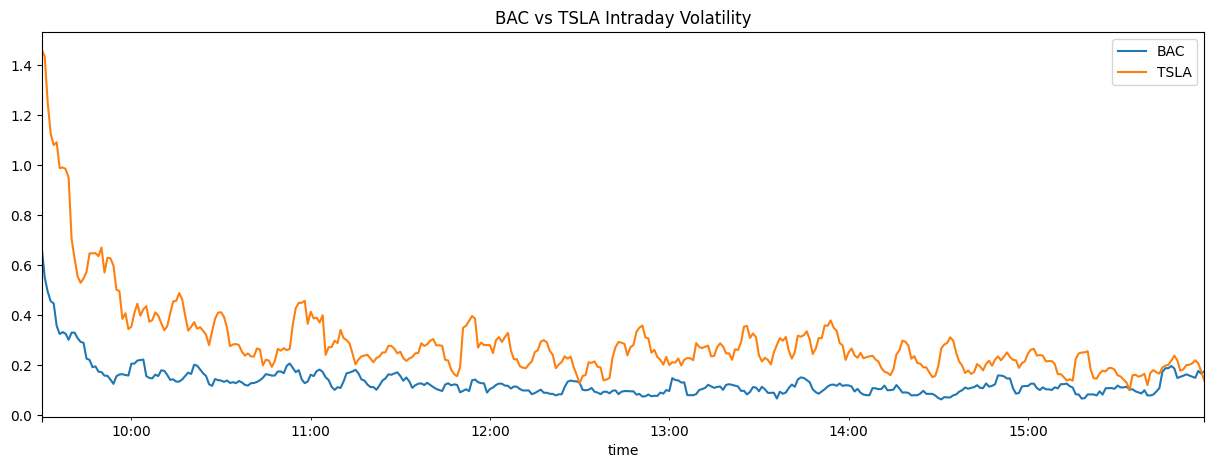

In [28]:
%%py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('default')
mpl.rcParams["figure.figsize"] = [15,5]
# check that we can now plot s
s.plot(title='BAC vs TSLA Intraday Volatility')


### Part J (2 Points)

Pulling everything together, this question asks you to summarize the
notional traded by each stock in the dataset in minutely buckets.  The
term 'notional' represents the traded value in units of dollars.  The
`size` column is not comparable between `BAC` and `TSLA`, but the
notional (size x price) is.  Sum each stock's total notional traded
within each minute bucket, pivot the table and assign the result to
the variable `v` in the python namespace.


In [29]:
v:{update BAC:first each BAC, TSLA:first each TSLA from x} pivot select sum size*price by 0D00:01 xbar time, sym from filter[`BAC`TSLA;t]
.pykx.set[`v] .pykx.topd v

In [30]:
/ confirm v has the desired columns
assert[`time`BAC`TSLA] cols .pykx.get[`v]`
/ confirm v has the desired row count
assert[390] count .pykx.get[`v]`
/ confirm v has the correct data
assert[`BAC`TSLA!2158426 3850987] rnd[1] avg .pykx.get[`v]`

<Axes: title={'center': 'BAC vs TSLA Intraday Volume'}, xlabel='time'>

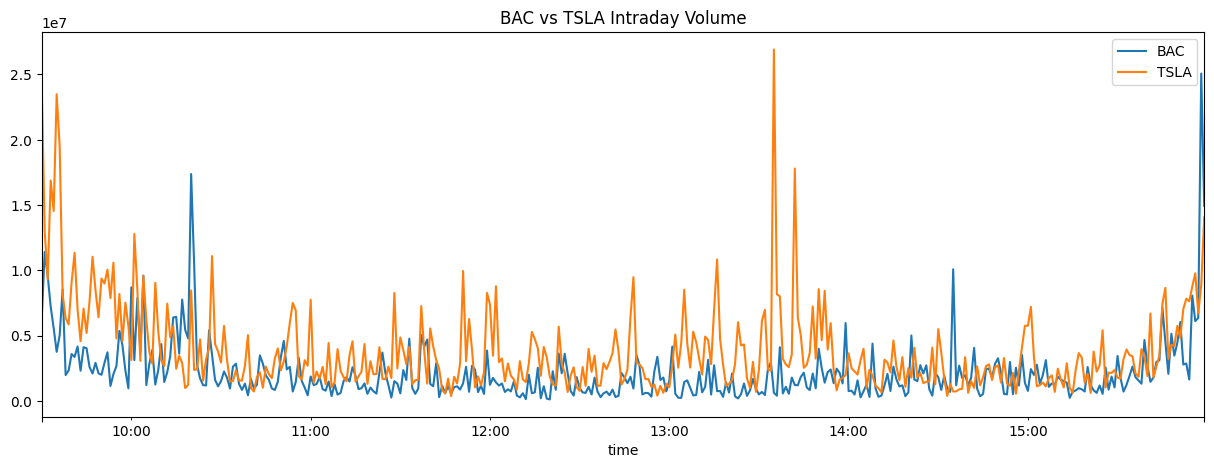

In [31]:
%%py
# check that we can now plot v
import pandas as pd
v.plot(title='BAC vs TSLA Intraday Volume')
